# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

In [3]:
df = pd.read_csv("py_df.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's remove the sort files, then select users with the highest amount of files

- count lines

In [4]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    155359.000000
mean         50.815852
std          70.495160
min           0.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

- let's save files with amount of lines in range `[30; 100]`

In [5]:
df = df[(df.n_lines>=30)&(df.n_lines<=100)]
df.n_lines.describe()

count    96347.000000
mean        53.112406
std         17.997254
min         30.000000
25%         38.000000
50%         49.000000
75%         65.000000
max        100.000000
Name: n_lines, dtype: float64

- let's find avg file length (in chars)

In [6]:
df["n_chars"] = df.flines.apply(lambda x: len(str(x)))
(df.n_chars/df.n_lines).describe()

count    96347.000000
mean        25.218311
std         24.381574
min          9.404255
25%         21.201266
50%         24.256098
75%         27.609035
max       2305.270270
dtype: float64

- suspicious max value let's drop evetyrhing, highter then `100` and look, what's left

In [7]:
df["chars_per_line"] = df.n_chars/df.n_lines
df = df[df.chars_per_line<100]
df.describe()

,year,n_lines,n_chars,chars_per_line
count,96268.000000,96268.000000,96268.000000,96268.000000
mean,2013.419059,53.110462,1320.138987,24.737484
std,2.275480,17.996703,556.480639,5.274293
min,2008.000000,30.000000,322.000000,9.404255
25%,2012.000000,38.000000,903.000000,21.200000
50%,2014.000000,49.000000,1193.000000,24.250000
75%,2016.000000,65.000000,1622.000000,27.600000
max,2016.000000,100.000000,8109.000000,98.937500


- less, then 100 files were removed

- let's look at the amount of files per participant

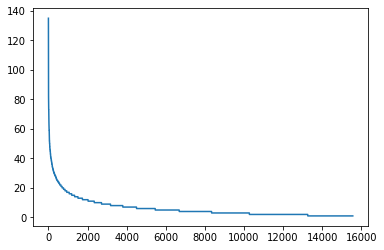

In [8]:
plt.plot(np.array(df.username.value_counts()))

- Let's collect `20` users with avg amount of files, which is around 100
(enough files, but their difference amount is not sufficient)

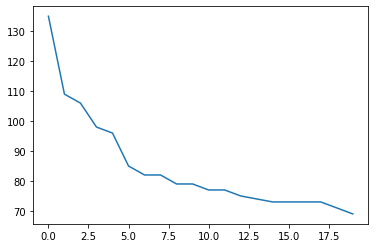

In [9]:
plt.plot(np.array(df.username.value_counts())[:20])

In [10]:
users = df.username.value_counts()[:20].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833
23,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353
28,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474


- Let's look at the amount of files per person in more details

In [11]:
df.username.value_counts().describe()

count     20.000000
mean      84.300000
std       16.645214
min       69.000000
25%       73.000000
50%       78.000000
75%       87.750000
max      135.000000
Name: username, dtype: float64

- Hope, this is enough and the contrast between the smallest amount and the max, won't be sufficient

## Embedding

In [12]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
sp.encode('\tarr = [int(x) for x in str.split()]')

[6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]

In [13]:
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))

arr = [int(x) for x in str.split()]


- **we loose layout features!**

In [14]:
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1686.000000,1686.000000,1686.00000,1686.000000,1686.000000
mean,2012.897390,58.486358,1444.54745,24.543324,371.159549
std,2.291935,18.141141,558.78286,4.619417,150.535618
min,2008.000000,30.000000,531.00000,14.732558,118.000000
25%,2011.000000,44.000000,1032.00000,21.746667,265.000000
50%,2013.000000,56.000000,1358.00000,24.121212,344.000000
75%,2015.000000,72.000000,1762.75000,26.712798,455.000000
max,2016.000000,100.000000,5948.00000,75.291139,2768.000000


- rm files with amount of tokens less greater, then 500

In [15]:
df = df[df.n_tokens<=500]
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2012.917143,53.568571,1271.022143,23.829132,322.826429
std,2.290919,15.063492,390.018832,3.958509,91.062134
min,2008.000000,30.000000,531.000000,14.732558,118.000000
25%,2011.000000,41.000000,960.000000,21.412698,250.000000
50%,2013.000000,52.000000,1248.000000,23.529583,321.000000
75%,2015.000000,64.000000,1531.250000,25.878261,393.000000
max,2016.000000,99.000000,2966.000000,42.854545,500.000000


-  let's hope, that `min = 21` is ok

In [16]:
df.username.value_counts()

EricStansifer     124
lidaobing          98
RalfKistner        84
gizzywump          75
gepa               71
kmod               71
waitingkuo0527     70
Michael            70
Fj.                69
mth                66
pawko              65
mihaild            64
nitsas             63
xtof.durr          63
Sp3000             63
addie9000          63
narri              62
linguo             57
d.operator         56
graygrass          46
Name: username, dtype: int64

In [17]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [18]:
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line,n_tokens,tokens
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512,297,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000,335,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833,250,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353,480,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474,285,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."


In [19]:
dataset = df[["username", "tokens"]]

In [20]:
dataset

,username,tokens
0,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,RalfKistner,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,lidaobing,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,lidaobing,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,gizzywump,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
1678,Michael,"[138, 4159, 138, 1149, 63, 921, 96077, 682, 58..."
1682,d.operator,"[46, 18331, 2365, 676, 2479, 96084, 233, 96124..."
1683,d.operator,"[46, 18331, 2365, 676, 2479, 96084, 233, 96124..."
1684,d.operator,"[46, 18331, 2365, 676, 2479, 96084, 233, 96124..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [21]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
1405,5,"[138, 1149, 138, 6912, 63, 3376, 96077, 8612, ..."
983,2,"[138, 1149, 63, 921, 96077, 682, 586, 121, 114..."
1420,9,"[138, 566, 299, 34055, 96091, 614, 45, 63, 321..."
288,14,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
221,2,"[138, 1149, 63, 921, 96077, 3513, 96077, 682, ..."
...,...,...
1157,0,"[46, 1536, 31455, 156, 4158, 138, 250, 63, 253..."
1633,15,"[138, 1149, 63, 178, 2374, 586, 115, 1084, 57,..."
1450,11,"[138, 1149, 138, 2684, 63, 7916, 96091, 96075,..."
1173,12,"[63, 6803, 96091, 5, 1365, 45, 70, 96105, 9608..."


In [23]:
def rsh(x):
    arr = np.array(x)
    arr.resize(500)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [24]:
dataset

,username,tokens
1405,5,"[138, 1149, 138, 6912, 63, 3376, 96077, 8612, ..."
983,2,"[138, 1149, 63, 921, 96077, 682, 586, 121, 114..."
1420,9,"[138, 566, 299, 34055, 96091, 614, 45, 63, 321..."
288,14,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
221,2,"[138, 1149, 63, 921, 96077, 3513, 96077, 682, ..."
...,...,...
1157,0,"[46, 1536, 31455, 156, 4158, 138, 250, 63, 253..."
1633,15,"[138, 1149, 63, 178, 2374, 586, 115, 1084, 57,..."
1450,11,"[138, 1149, 138, 2684, 63, 7916, 96091, 96075,..."
1173,12,"[63, 6803, 96091, 5, 1365, 45, 70, 96105, 9608..."


In [25]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(1400, 500)

In [26]:
X = X.reshape((-1, 500, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(1050, 500, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [51]:
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 491, 150)          1650      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 61, 150)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9150)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 9150)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                585664    
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)               

In [52]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [53]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
52/52 - 1s - loss: 13984887.0000 - accuracy: 0.1062 - val_loss: 14515340.0000 - val_accuracy: 0.1829
Epoch 2/100
52/52 - 1s - loss: 26092528.0000 - accuracy: 0.2005 - val_loss: 26890764.0000 - val_accuracy: 0.3400
Epoch 3/100
52/52 - 1s - loss: 80722776.0000 - accuracy: 0.2170 - val_loss: 78943864.0000 - val_accuracy: 0.2800
Epoch 4/100
52/52 - 1s - loss: 147038864.0000 - accuracy: 0.2766 - val_loss: 106388136.0000 - val_accuracy: 0.3257
Epoch 5/100
52/52 - 1s - loss: 166961008.0000 - accuracy: 0.3361 - val_loss: 156073104.0000 - val_accuracy: 0.4086
Epoch 6/100
52/52 - 1s - loss: 201975936.0000 - accuracy: 0.3828 - val_loss: 186361776.0000 - val_accuracy: 0.4286
Epoch 7/100
52/52 - 1s - loss: 221577664.0000 - accuracy: 0.4377 - val_loss: 235092080.0000 - val_accuracy: 0.5457
Epoch 8/100
52/52 - 1s - loss: 277531584.0000 - accuracy: 0.4515 - val_loss: 313194592.0000 - val_accuracy: 0.5371
Epoch 9/100
52/52 - 1s - loss: 250069904.0000 - accuracy: 0.5641 - val_loss: 267062624

In [27]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

f = plot_training(history)

NameError: name 'history' is not defined

#### 64% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 77% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 81%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 81.71%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 80%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

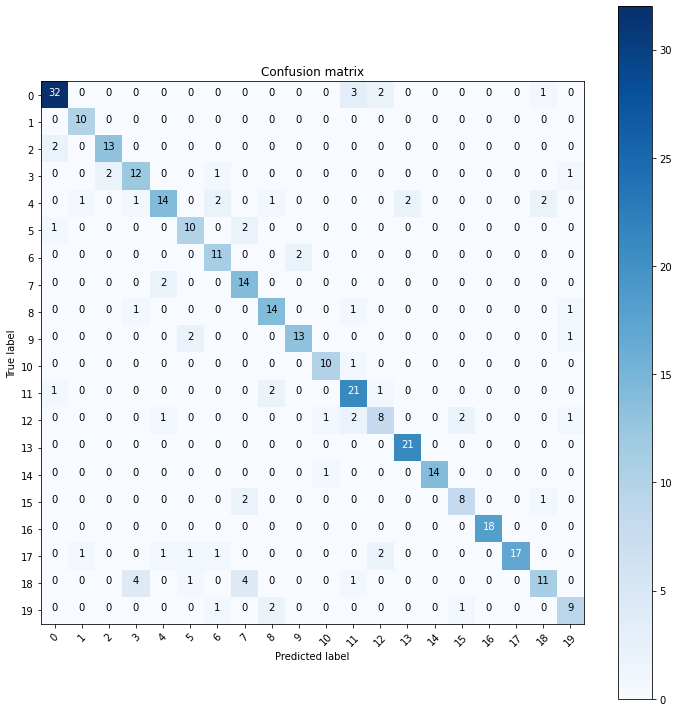

In [55]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))

In [56]:
model.save('model.h5')

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
print(X.min(), X.mean(), X.max())

0 18006.075955714285 96164


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [31]:
ss = StandardScaler()
X = X.reshape((-1, 500))
X = ss.fit_transform(X)
X = X.reshape((-1, 500, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(1050, 500, 1)

In [84]:
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 485, 64)           1088      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 60, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 57, 32)            8224      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 224)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 224)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)              

In [85]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [86]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
52/52 - 1s - loss: 3.1951 - accuracy: 0.0870 - val_loss: 2.6906 - val_accuracy: 0.2200
Epoch 2/100
52/52 - 1s - loss: 2.7350 - accuracy: 0.2152 - val_loss: 2.3566 - val_accuracy: 0.3486
Epoch 3/100
52/52 - 1s - loss: 2.4720 - accuracy: 0.2866 - val_loss: 1.8447 - val_accuracy: 0.4657
Epoch 4/100
52/52 - 0s - loss: 2.4828 - accuracy: 0.3196 - val_loss: 1.8237 - val_accuracy: 0.4829
Epoch 5/100
52/52 - 1s - loss: 2.4649 - accuracy: 0.3315 - val_loss: 1.9612 - val_accuracy: 0.4571
Epoch 6/100
52/52 - 1s - loss: 2.4506 - accuracy: 0.3260 - val_loss: 1.7664 - val_accuracy: 0.4886
Epoch 7/100
52/52 - 1s - loss: 2.4044 - accuracy: 0.3443 - val_loss: 1.6923 - val_accuracy: 0.5286
Epoch 8/100
52/52 - 0s - loss: 2.3946 - accuracy: 0.3672 - val_loss: 1.6624 - val_accuracy: 0.5286
Epoch 9/100
52/52 - 1s - loss: 2.2628 - accuracy: 0.3892 - val_loss: 1.5931 - val_accuracy: 0.5514
Epoch 10/100
52/52 - 0s - loss: 2.4094 - accuracy: 0.3773 - val_loss: 1.4267 - val_accuracy: 0.5686
Epoch 11/

#### 80% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 82%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 86% up to 87%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 83%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

In [87]:
model.save('86_model.h5')

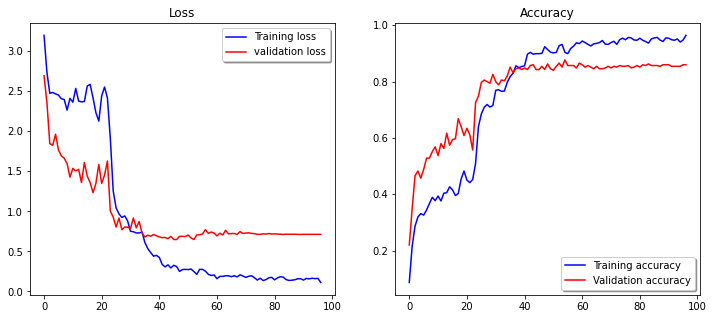

In [88]:
f = plot_training(history)

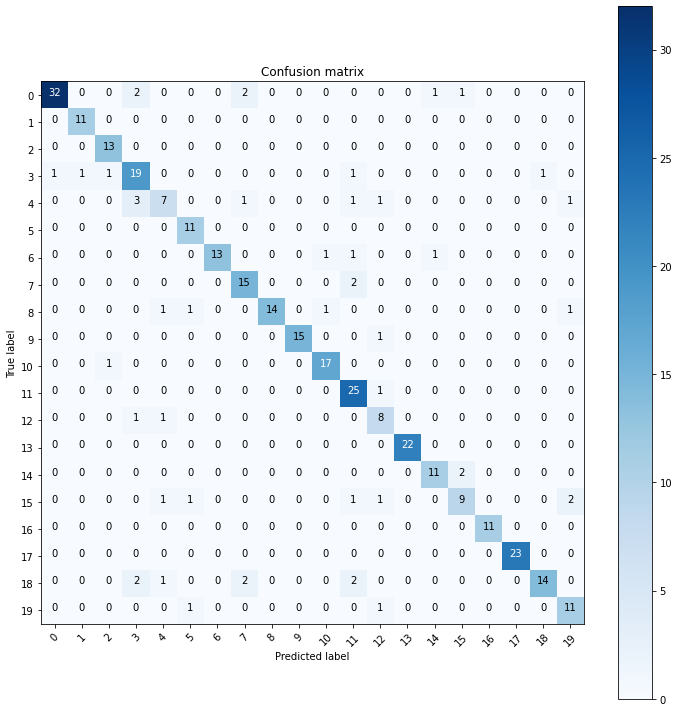

In [89]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))

## Triplet loss
- useful [link1](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ ), [link2](https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend)

### Main idea (If I understood correctly)
- create embedding for embeddings (?)
- apply KNN to find the closest vectors - if the problem is related to the classification

### Data preprocessing flow:
1. Split X[-1, 500] on pices of [-1, 100] and increase the dimensionality of array
2. Shuffle ???
3. Create batch_loader:
        3.1. Select anchor samples (**TODO** search if it is usually done sequentially or randomly)
        3.2. Select some X, where y is the same (random or sequential???)
        3.3. Select some X, where y is different (random or sequential???)
4. Create model (e.g. Sequential)
5. Concatenate 3 models for anchor, positives an negatives // this is exactly the parallel convolution, which I was searching during the previous stages
6. Create a functions `loss` and `data_generator`
7. Train model with dummy y (e.g 0) ([good example](https://github.com/AdrianUng/keras-triplet-loss-mnist#visualizing-separation-of-classes ), [their code](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb))
8. Apply the visualization with PCA/test on KNN????

### Make samples smaller, e.g. 100
- potential problem - files are ended with zeros, if amount of tokens is less


In [32]:
def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, 100):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(np.argmax(old_y))
    
    new_X = np.array(new_X)
    new_y = np.array(new_y)
    return new_X, new_y

# new_X, new_y = crop_to(X, y)
new_X, new_y = X, y

In [33]:

data_length = new_y.shape[0]

### Shuffle - do I need this?
- No, because in the batch I'm going to use random

### Batch generation

In [34]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=500):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        


### Model creation


- let's repeat the best arch

In [35]:
import tensorflow as tf
from tensorflow.keras import regularizers


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [36]:
params = {
    "activations" : ["tanh", "relu", "elu", "sigmoid", "linear", "selu", "gelu", "swish"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.01, 0.001, 0.0001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [16, 32, 64],
    "conv_2_size":[4, 8],
    "dense_1": [64, 128]   
}

In [37]:
output_size = 50
input_size = 500

In [38]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    return model_core


In [39]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size
    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)

    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [40]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size, 1))
    input_positive = layers.Input(shape=(input_size, 1))
    input_negative = layers.Input(shape=(input_size, 1))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model


In [41]:
def train(new_X, new_y, input_size, model):
    batch_size = 64
    epochs = 100
    steps_per_epoch = int(new_X.shape[0]/batch_size)

    optimizer = optimizers.Adam(0.1)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
    early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)

    model.compile(loss=triplet_loss, optimizer=optimizer)
    history = model.fit(data_generator(new_X, np.argmax(new_y, axis=1), batch_size, input_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        verbose=0, 
                        callbacks=[lr_schedule, early_stopping])
    return model, history


In [42]:
def test(model_core, new_X, new_y):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)

    knn = KNeighborsClassifier(n_neighbors=3, algorithm="ball_tree", weights="distance")
    knn.fit(X_train, np.argmax(y_train, axis=1))
    y_pred = knn.predict(X_test)
    
    score = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    return score
    

In [43]:
param_list = []
for key in params.keys():
    if len(param_list)==0:
        for x in params[key]:
            param_list.append([x])
    else:
        new_param_list = []
        for l in param_list:
            for x in params[key]:
                l_copy = l.copy()
                l_copy.append(x)
                new_param_list.append(l_copy)
        param_list = new_param_list
len(param_list)

1152

In [44]:
param_list[0]

['tanh', 0.01, 4, 4, 16, 4, 64]

In [1]:
import tqdm

In [ ]:
max_score = 0
best_model = None
log = []
for p in tqdm.tqdm(param_list):
    core_model = create_model(*p)
    triplet = create_triplet_model(input_size, core_model)
    model, history = train(new_X, new_y, input_size, triplet)
    score = test(core_model, new_X, new_y)
    if score > max_score:
        max_score = score
        best_model = model
        print(p, score)
    log.append({"score": score, "history": history, "params": p})



  0%|          | 1/1152 [01:47<34:28:05, 107.81s/it]

['tanh', 0.01, 4, 4, 16, 4, 64] 0.5257142857142857



  2%|▏         | 21/1152 [37:17<34:00:25, 108.25s/it]

['tanh', 0.01, 4, 8, 64, 4, 64] 0.5485714285714286



  2%|▏         | 26/1152 [47:01<33:02:16, 105.63s/it]

['tanh', 0.01, 8, 4, 16, 4, 128] 0.5571428571428572



 14%|█▍        | 160/1152 [5:05:28<24:12:38, 87.86s/it]

['relu', 0.01, 4, 8, 16, 8, 128] 0.5628571428571428



 22%|██▏       | 249/1152 [7:35:39<30:38:04, 122.13s/it]

['relu', 0.0001, 4, 4, 64, 4, 64] 0.5714285714285714



 24%|██▍       | 281/1152 [8:40:22<28:52:08, 119.32s/it]

['relu', 0.0001, 8, 8, 32, 4, 64] 0.5885714285714285



 32%|███▏      | 368/1152 [10:50:08<26:51:29, 123.33s/it]

['elu', 0.001, 8, 4, 32, 8, 128] 0.5942857142857143



 60%|██████    | 695/1152 [20:25:05<17:34:14, 138.41s/it]

['linear', 0.0001, 4, 8, 64, 8, 64] 0.62



 68%|██████▊   | 779/1152 [22:43:00<18:21:09, 177.13s/it]

### Top-models
#### 43.4%
```python
output_size = 40
model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 16, activation="linear")) 
model_core.add(layers.AveragePooling1D(pool_size=4))#6 -slow down
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(64, activation="linear", kernel_regularizer=regularizers.L2(0.0001)))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear", kernel_regularizer=regularizers.L2(0.0001)))
```
#### 43.14%
```python
output_size = 40

model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="tanh")) 
model_core.add(layers.AveragePooling1D(pool_size=8))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(128, activation="linear"))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear"))
```
#### 43.71%
```python
output_size = 40

model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="tanh")) 
model_core.add(layers.AveragePooling1D(pool_size=4))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(128, activation="linear"))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear"))
```
#### 46.8%
```python
output_size = 40

model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="tanh")) 
model_core.add(layers.AveragePooling1D(pool_size=6))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(128, activation="linear"))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear"))
```
#### 44.2%
```python
output_size = 40
model_core = keras.Sequential()
model_core.add(layers.Conv1D(128, 32, activation="linear")) 
model_core.add(layers.AveragePooling1D(pool_size=6))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(64, activation="linear", kernel_regularizer=regularizers.L2(0.001)))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear", kernel_regularizer=regularizers.L2(0.001)))
```
#### 44.17%
```python
output_size = 40
model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="tanh", strides=2, kernel_regularizer = regularizers.L2(0.001))) 
model_core.add(layers.AveragePooling1D(pool_size=8))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(64, activation="linear"))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear"))
```


#### 45.7%
```python
output_size = 40
model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="linear", kernel_regularizer = regularizers.L2(0.001))) 
model_core.add(layers.AveragePooling1D(pool_size=8))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(64, activation="linear", kernel_regularizer = regularizers.L2(0.0001)))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear", kernel_regularizer = regularizers.L2(0.0001)))
```

#### 47%, 100 epochs, samples out of 100
```python
output_size = 30
model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="linear", kernel_regularizer = regularizers.L2(0.001))) 
model_core.add(layers.AveragePooling1D(pool_size=8))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(64, activation="linear", kernel_regularizer = regularizers.L2(0.0001)))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear", kernel_regularizer = regularizers.L2(0.0001)))
```

### 500 tokens per 1 person

#### 55.1%
```python
output_size = 40
input_size = 500
model_core = keras.Sequential()
model_core.add(layers.Conv1D(64, 32, activation="tanh")) 
model_core.add(layers.AveragePooling1D(pool_size=6))
model_core.add(layers.Flatten())
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(128, activation="linear"))
model_core.add(layers.Dropout(0.5))
model_core.add(layers.Dense(output_size, activation="linear"))
```

#### up to 62.8% - nothing is better
```python

model = keras.Sequential()
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(output_size, activation="linear"))
```


### Read more
- [implementation by tensorflow](https://www.tensorflow.org/addons/tutorials/losses_triplet)